# RDS Homework 3 Template
## Spring 2023


In [1]:
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 572.4/572.4 kB 8.4 MB/s eta 0:00:00


In [2]:
from __future__ import print_function

import shap
import sklearn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.ensemble
import sklearn.metrics
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import tqdm
from sklearn.linear_model import SGDClassifier
from sklearn.datasets import fetch_20newsgroups
from collections import defaultdict
from nltk.tokenize import word_tokenize
import nltk
nltk.download('punkt')

# Configs
np.random.seed(1)
shap.initjs()
sns.set_style("whitegrid")

plot_shap=True # NOTE: Turn False to disable shap plots as they can be slow to load 

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


## Problem 3

### Part (A)

In [3]:
# Mark the categories of interest
categories = ['alt.atheism', 'soc.religion.christian']

# Fetch the data
newsgroups_train = fetch_20newsgroups(subset='train', categories=categories)
newsgroups_test = fetch_20newsgroups(subset='test', categories=categories)

# Set outcome class names
class_names = ['atheism', 'christian']

In [78]:
# Initialize & fit tf-idf vectorizer
tfidf = TfidfVectorizer(lowercase = False)

x_train = tfidf.fit_transform(newsgroups_train.data).toarray()
x_test = tfidf.transform(newsgroups_test.data).toarray()


In [79]:
# Train & fit the classifier
y_train = newsgroups_train.target
y_test = newsgroups_test.target
clf = SGDClassifier(random_state = 1)
clf.fit(x_train, y_train)

SGDClassifier(random_state=1)

### Part (B)

In [80]:
# Confusion Matrix
y_pred = clf.predict(x_test)
CM = sklearn.metrics.confusion_matrix(y_test, y_pred)
print(CM)

[[284  35]
 [  3 395]]


#### Explainer

In [105]:
# Initialize the explainer and apply to test data
# Initialize the explainer
import pandas as pd
explainer = shap.Explainer(clf, x_test)
# Apply it to the test data
shap_values = explainer(pd.DataFrame(x_test, columns = tfidf.get_feature_names_out()))

In [118]:
# Select 5 documents in the test set for explanation
random_idx = np.array([4, 185, 347, 216, 223])
print(random_idx)
print(y_pred[random_idx] == y_test[random_idx])


[  4 185 347 216 223]
[False  True  True False  True]


index: 4, the accuracy of prediction: False


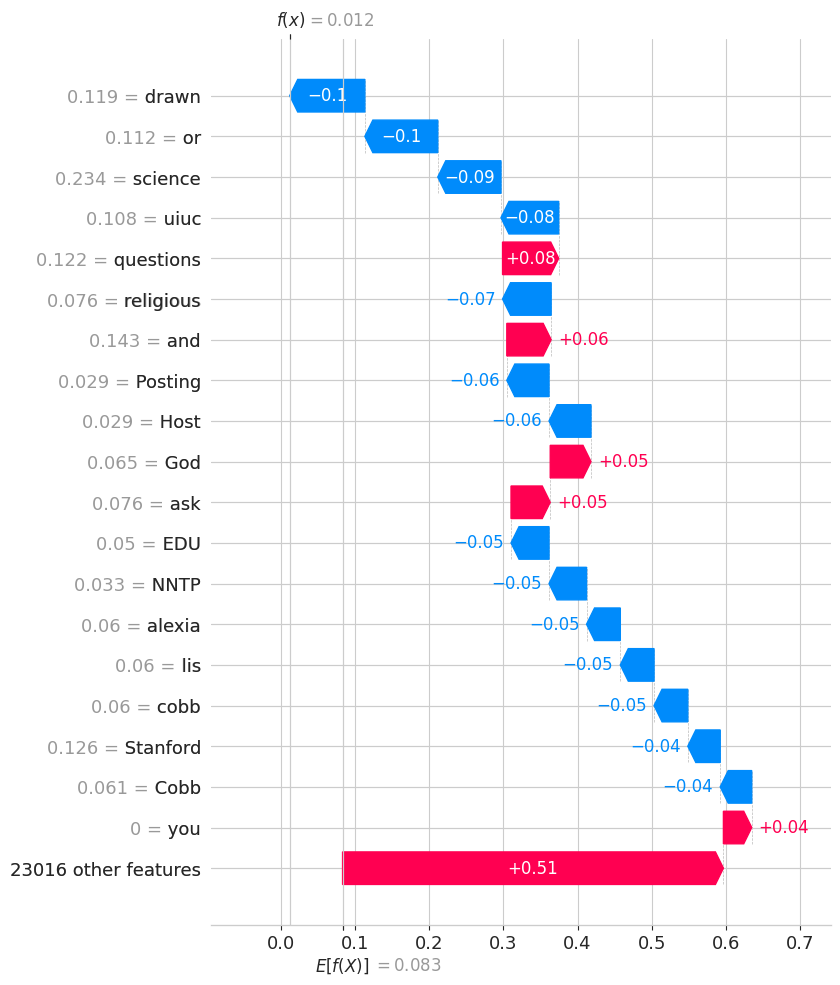

index: 185, the accuracy of prediction: True


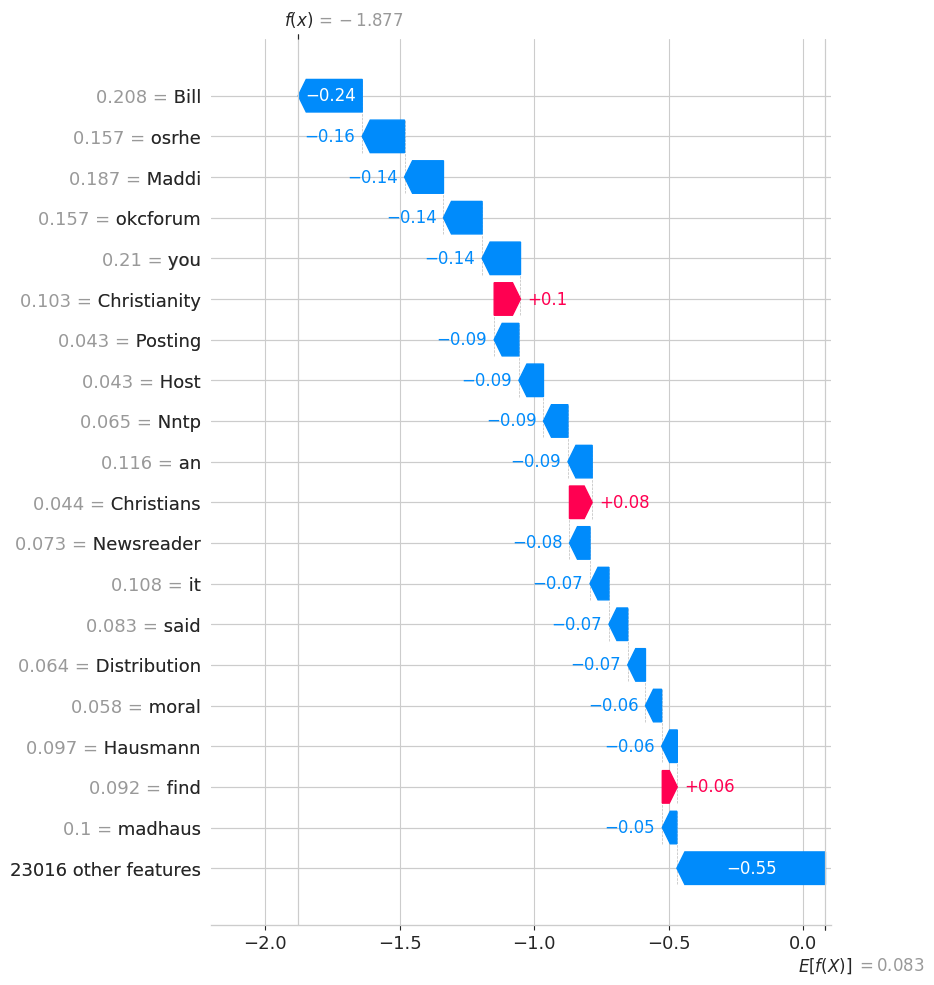

index: 347, the accuracy of prediction: True


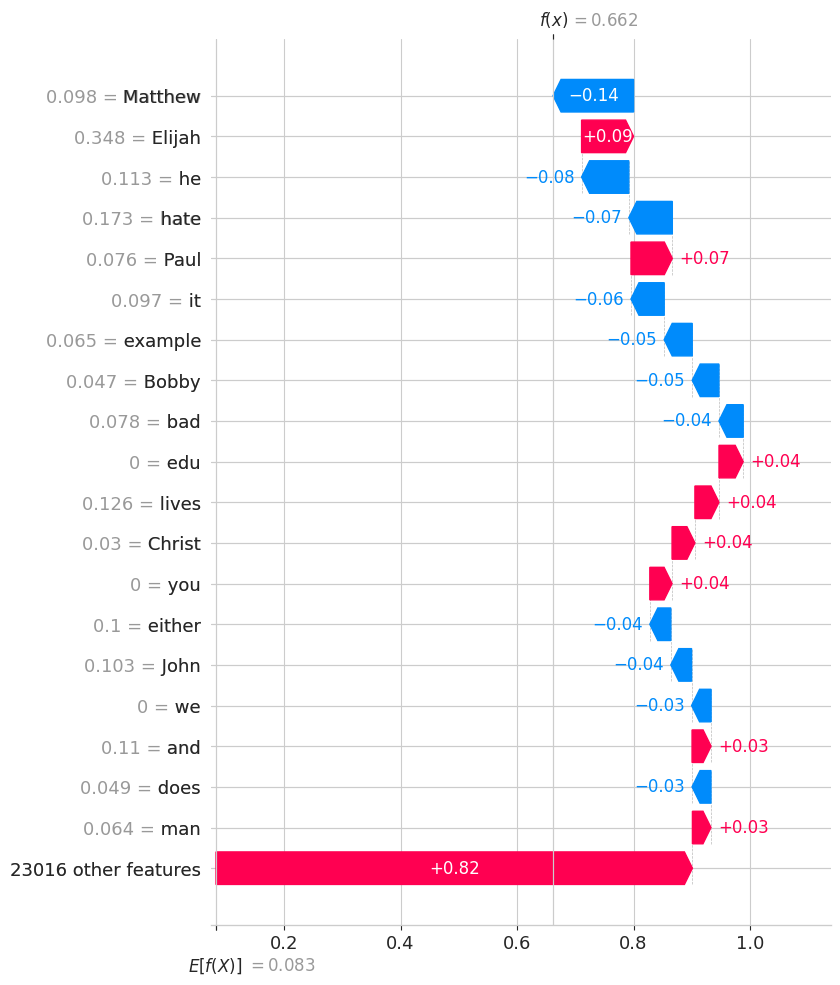

index: 216, the accuracy of prediction: False


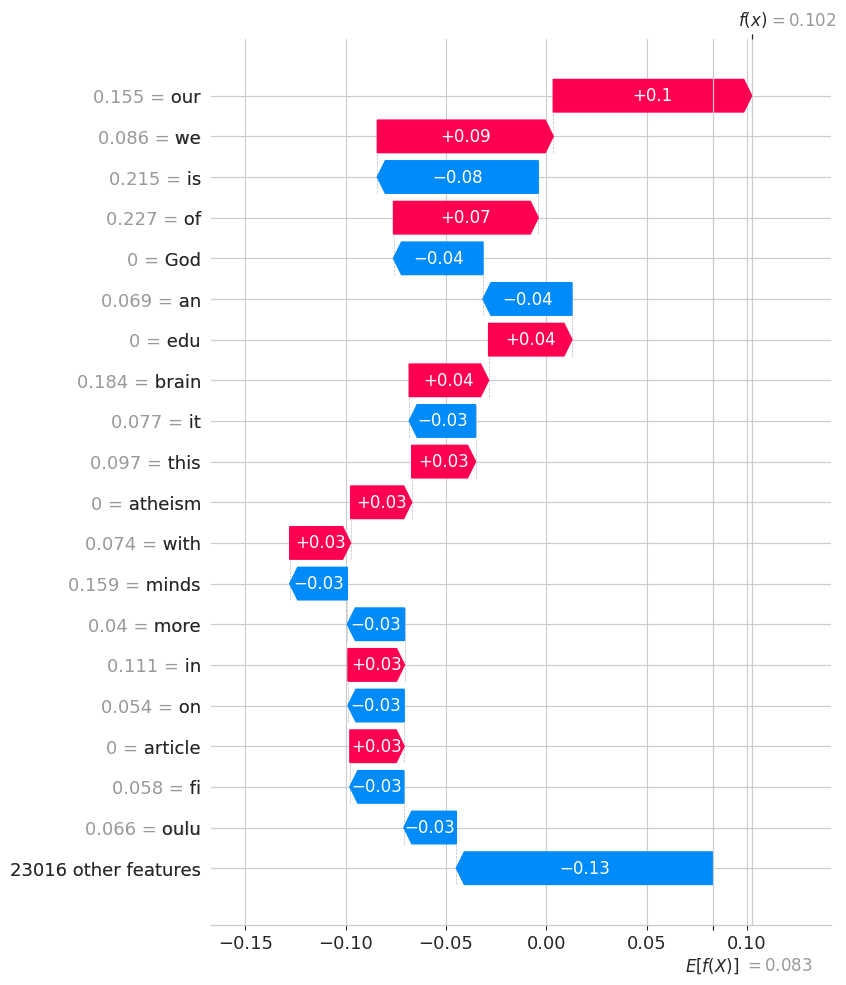

index: 223, the accuracy of prediction: True


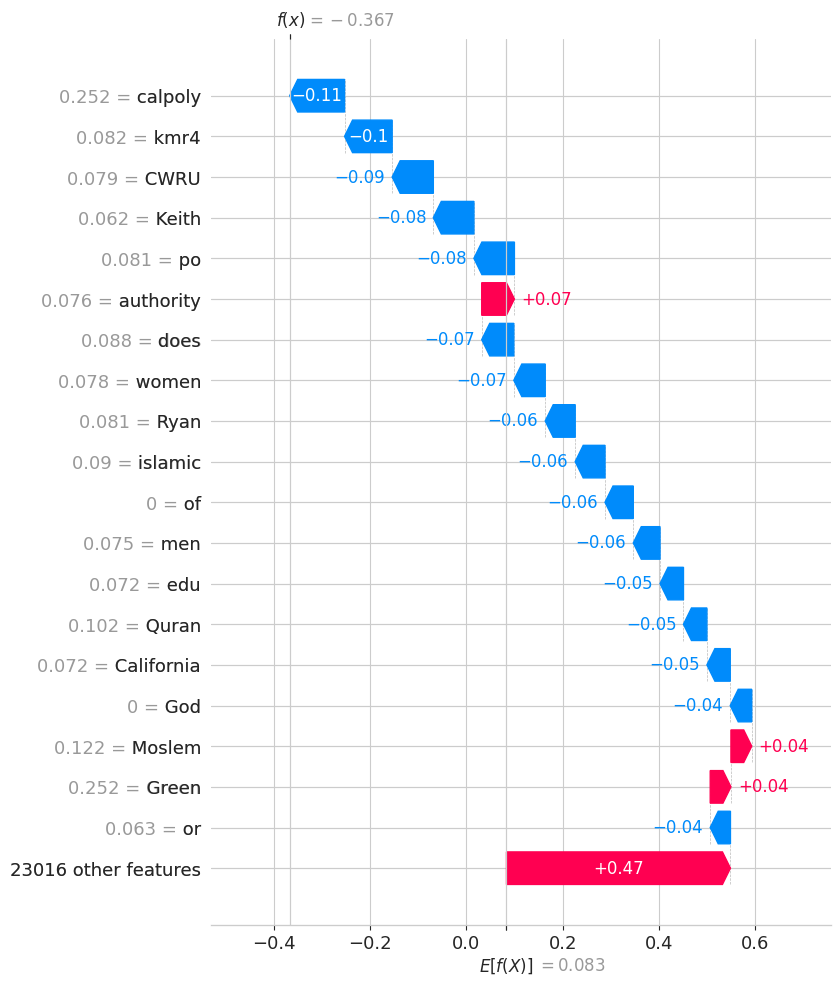

In [119]:
# Visually explain 5 documents selected from the test set
# shape_values_select = shap_values[random_idx]
for idx in random_idx:
  # show the top-20 features
  print("index: %d, the accuracy of prediction:"%idx, y_pred[idx] == y_test[idx])
  shap.plots.waterfall(shap_values[idx], max_display=20)

### Part (C)


#### Part (i)

In [129]:
# Compute the accuracy of the classifier and the number of misclassified documents
acc = sklearn.metrics.accuracy_score(y_test, y_pred)
tmp = (y_test != y_pred)
misclassified_ids = []
for i in range(len(tmp)):
  if tmp[i]:
    misclassified_ids.append(i)
misclassified_num = len(misclassified_ids)
print("the accuracy of the classifier:", acc)
print("the number of misclassified documents:", misclassified_num)

the accuracy of the classifier: 0.9470013947001394
the number of misclassified documents: 38


#### Part (ii)

In [157]:
# Calculate conf_i for all misclassified documents
conf_list = []
from sklearn.calibration import CalibratedClassifierCV
calibrator = CalibratedClassifierCV(clf, cv='prefit')
model=calibrator.fit(x_train, y_train)
y_prob = model.predict_proba(x_test)
for idx in misclassified_ids:
  conf_list.append(abs(y_prob[idx][0] - y_prob[idx][1]))

Text(0.5, 1.0, "conf's histogram")

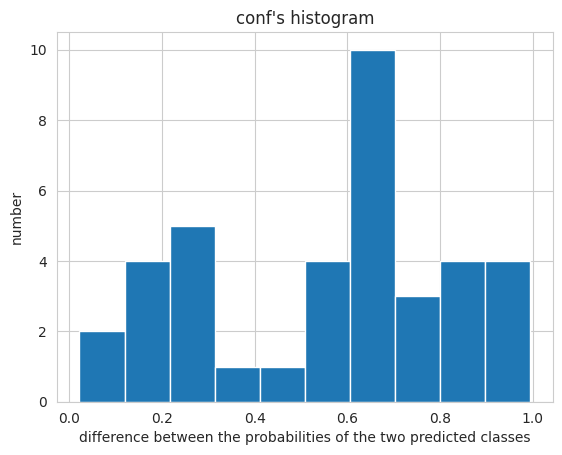

In [163]:
# Plot conf_i
plt.hist(conf_list)
plt.xlabel("difference between the probabilities of the two predicted classes")
plt.ylabel("number")
plt.title("conf's histogram")

#### Part (iii)

In [181]:
# Identify tokens (word_j) that contributed to the misclassification of documents
word_list = []
shap_arr = []
for idx in misclassified_ids:
  shap_v = explainer.shap_values(x_test[idx])
  shap_arr.append(shap_v)
  b = 1
  if y_test[idx] == 0:
    b = -1
  tmp = []
  for k in range(len(shap_v)):
    if b * shap_v[k] < 0:
      tmp.append(k)
  
  word_list.append(tmp)

In [192]:
# Compute the number of documents (count_j) these words helped to misclassify
count = {}
contribute = {}
for i in range(len(word_list)):
  wl = word_list[i]
  for k in wl:
    if k not in count:
      count[k] = 0
      contribute[k] = [i]
    else:
      count[k] += 1
      contribute[k].append(i)

In [193]:
# Compute the sum of absolute SHAP values (weight_j) for each word_j
weights = {}
for word in contribute:
  sum_ = 0
  for k in contribute[word]:
    sum_ += abs(shap_arr[k][word])
  weights[word] = sum_


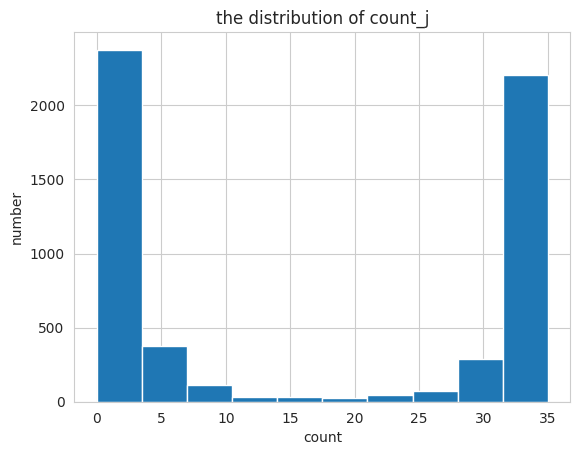

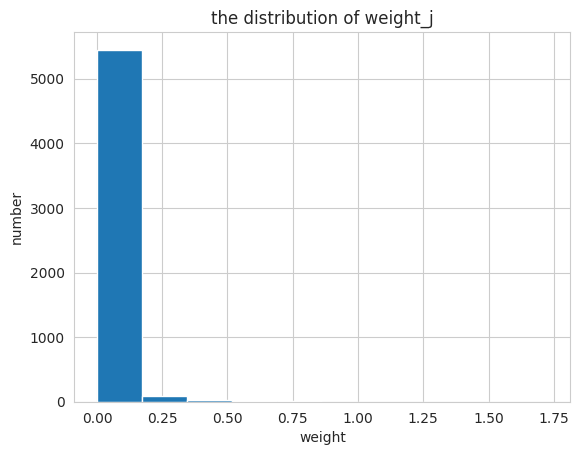

In [201]:
# Plot the distribution of count_j and weight_j
plt.hist(count.values())
plt.xlabel("count")
plt.ylabel("number")
plt.title("the distribution of count_j")
plt.show()
plt.close()
plt.hist(weights.values())
plt.xlabel("weight")
plt.ylabel("number")
plt.title("the distribution of weight_j")
plt.show()
plt.close()

### Part (D)

In [235]:
# Implement a strategy for feature selection

# delete features with high weight and count (according to Part C)
del_features = []
for word in count:
  if count[word] > 20 and weights[word] >= 0.12:
    del_features.append(word)
del_features = list(set(del_features))
x_train_new = np.delete(x_train, del_features, axis=1)
x_test_new = np.delete(x_test, del_features, axis=1)
print(len(del_features))

110


In [236]:
# Identify at least one example that was misclassified before feature selection and that is classified correctly after feature selection
clf_new = SGDClassifier(random_state = 1)
clf_new.fit(x_train_new, y_train)
y_pred_new = clf_new.predict(x_test_new)

acc_new = sklearn.metrics.accuracy_score(y_test, y_pred_new)
tmp = (y_test != y_pred_new)
misclassified_ids_new = []
for i in range(len(tmp)):
  if tmp[i]:
    misclassified_ids_new.append(i)
misclassified_num_new = len(misclassified_ids_new)
print("the accuracy of the classifier:", acc_new)
print("the number of misclassified documents:", misclassified_num_new)

the accuracy of the classifier: 0.9539748953974896
the number of misclassified documents: 33


In [237]:
print(misclassified_ids_new)
print(misclassified_ids)
# we can choose 4
idx = 4

[0, 13, 31, 38, 54, 62, 94, 121, 123, 134, 156, 164, 217, 222, 271, 280, 284, 377, 399, 413, 446, 447, 461, 469, 607, 610, 620, 623, 641, 658, 679, 685, 694]
[4, 38, 54, 94, 109, 123, 126, 134, 156, 164, 197, 216, 217, 293, 366, 399, 406, 413, 419, 442, 447, 460, 461, 469, 558, 568, 591, 610, 620, 623, 641, 658, 668, 677, 683, 685, 694, 703]


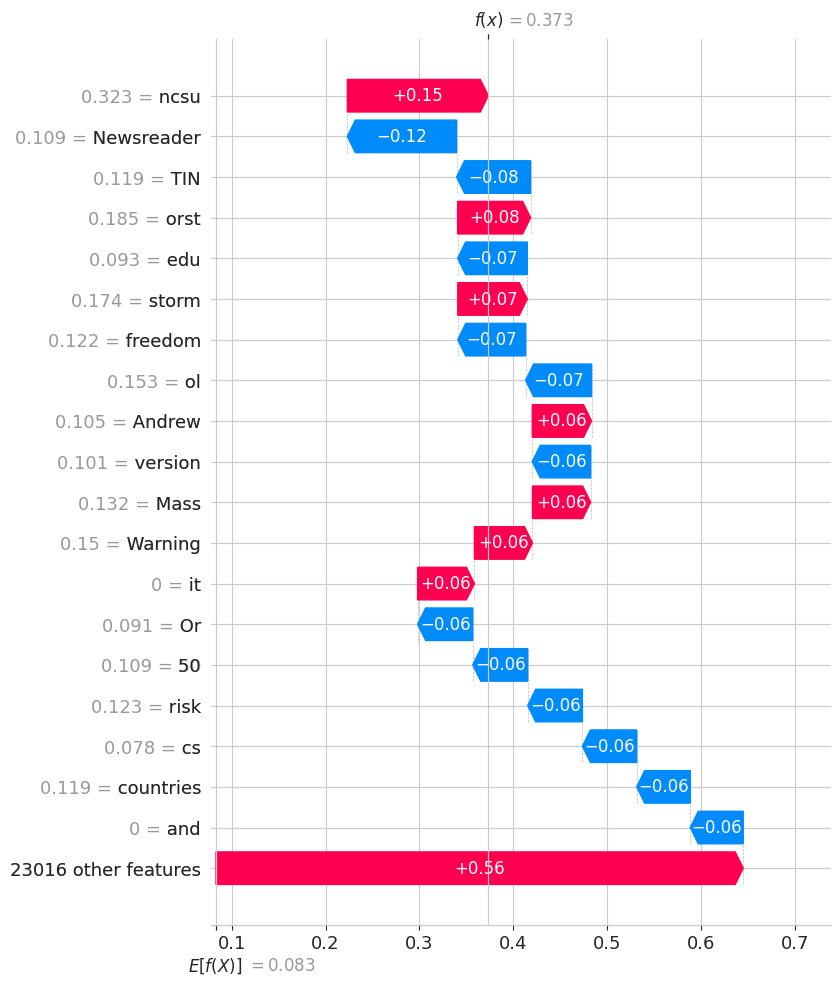

In [238]:
shap.plots.waterfall(shap_values[idx], max_display=20) # raw

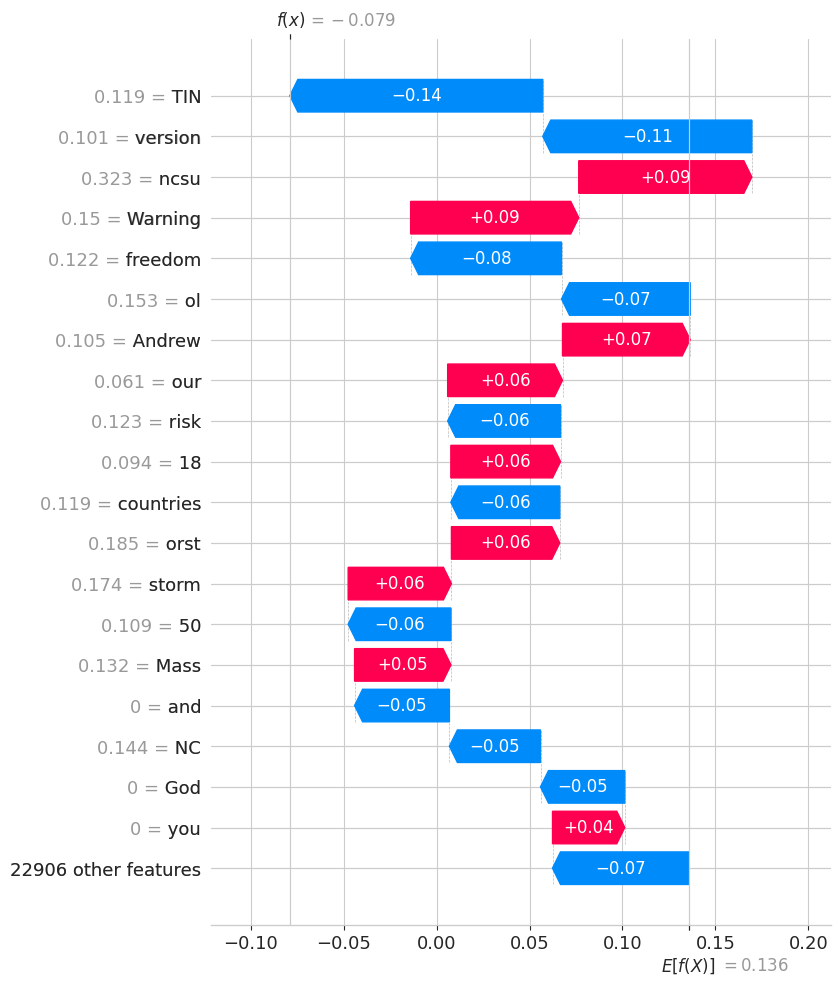

In [239]:
explainer_new = shap.Explainer(clf_new, x_test_new)
# Apply it to the test data
cols = tfidf.get_feature_names_out()
cols_new = np.delete(cols, del_features, axis=0)
shap_values_new = explainer_new(pd.DataFrame(x_test_new, columns = cols_new))
shap.plots.waterfall(shap_values_new[idx], max_display=20) # changed
